## Mixture Models

In [4]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from IPython.core.pylabtools import figsize

## Create synthetic data
500 points, randomly distributed between 3 clusters.
Clusters normally distributed with means [-5,0,5] and standard deviation 1

Cluster 0 : 156
Cluster 1 : 180
Cluster 2 : 164


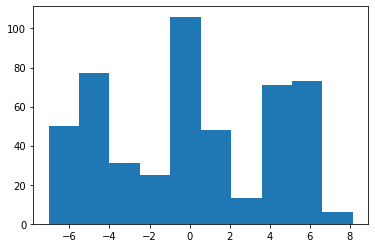

In [5]:
# simulate data from a known mixture distribution
np.random.seed(12345)  # set random seed for reproducibility
figsize(12, 6)
ndata = 500
spread = 5
centers = np.array([-spread, 0, spread])

# simulate data from mixture distribution
k = 3
v = np.random.randint(0, k, ndata)
counts = np.unique(v,return_counts=True)
[print(f"Cluster {i[0]} : {i[1]}") for i in zip(counts[0],counts[1])]

data = centers[v] + np.random.randn(ndata)

plt.hist(data);

In [8]:
# setup model
model = pm.Model()
with model:
    # cluster sizes
    p = pm.Dirichlet("p", a=np.array([1.0, 1.0, 1.0]), shape=k)

    # cluster centers
    means = pm.Normal("means", mu=[0, 0, 0], sigma=15, shape=k)

    # break symmetry
    order_means_potential= pm.Potential(
        "order_means_potential",
        pm.math.switch(means[1] - means[0] < 0, -np.inf, 0)
        + pm.math.switch(means[2] - means[1] < 0, -np.inf, 0),
    )

    # measurement error
    sd = pm.Uniform("sd", lower=0, upper=20)

    # latent cluster of each observation
    category = pm.Categorical("category", p=p, shape=ndata)

    # likelihood for each observed value
    points = pm.Normal("obs", mu=means[category], sigma=sd, observed=data)

## Create Emperical posterior distribution of parameters and visualise

In [11]:
with model:
    step1 = pm.Metropolis(vars=[p, sd, means])
    step2 = pm.CategoricalGibbsMetropolis(vars=[category])
    tr = pm.sample(10000, step=[step1, step2], tune=5000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [p]
>>Metropolis: [sd]
>>Metropolis: [means]
>CategoricalGibbsMetropolis: [category]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 1154 seconds.
/Users/sebastiangay/miniconda3/envs/bayes_env/lib/python3.10/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


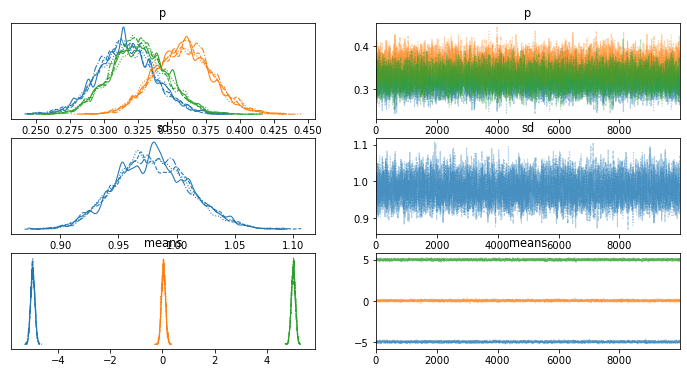

In [12]:
with model:
    az.plot_trace(tr, var_names=["p", "sd", "means"]);